# Shadow Ban Control on a Path Network

This notebook solves for an optimal shadow ban policy for a platform trying to optimize an objective.
We use the multiplier method iteration to solve for the policy.  The network is a path.




# Import packages

In [80]:
from importlib import reload

import os
import numpy as np
from scipy import integrate
from scipy.sparse import coo_matrix,diags, csr_matrix
import scipy
import math
import matplotlib.pyplot as plt
import networkx as nx
from networkx.readwrite import json_graph

import json

import matplotlib.cm as cm
from matplotlib.colors import Normalize
import seaborn as sns
import pandas as pd
import time
import random 

from typing import List, Set, Dict, Tuple
from scipy.integrate import odeint, ode
from scipy.interpolate import interp1d
import scipy.sparse as sp


from scripts.opinion_visualization import *
from scripts.content_moderation import *



## Shift function

Create function that gives the opinion shift and derivative of the opinion shift in the opinion dynamics.     For the opinion dynamics these functions are shift and dshift, respectively. You can have extra parameters for these functions, but the first argument is the opinion difference between the following and follower.  To be precise, if the opinion of the person tweeting
is $\theta_{tweet}$ and the opinion of the person who hears the tweet is $\theta$, then the input to the shift and dshift functions should be $x = \theta_{tweet}-\theta$. 

We define `shift_max` as the maximum of the shift function.  We need this when we solve for the bang bang policy of the agent.

 



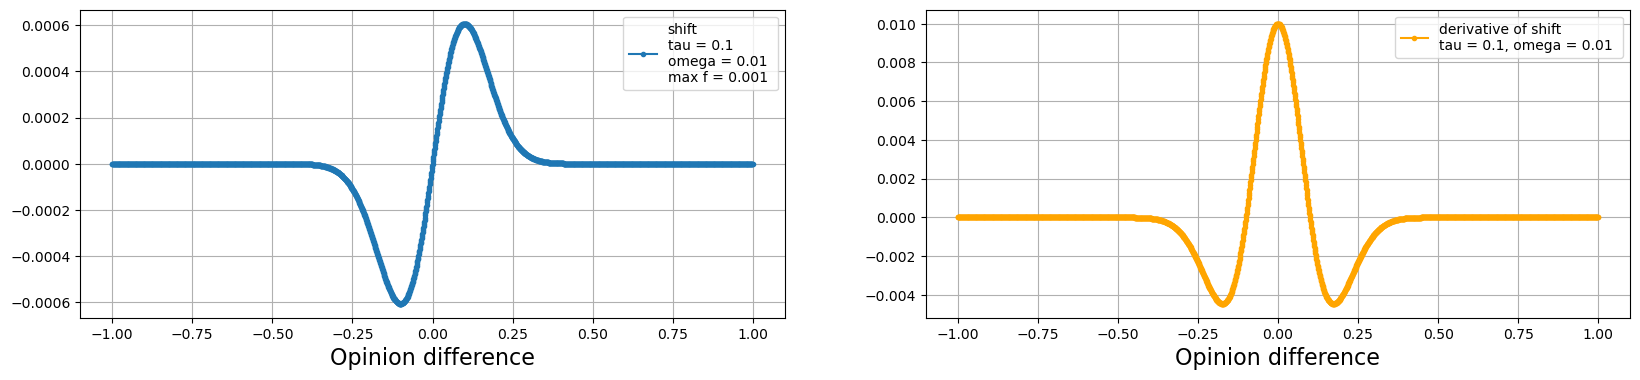

In [2]:
#opinion dynamics info
omega = .01 # strength of persuasion
tau = .1 # confidence interval, easiness to pursuade



x = np.arange(-1,1,.001)
shift_max = np.max(shift(x,tau,omega))


#plot the shift function to see how it looks
plt.figure(figsize =(20,4))
plt.subplot(1,2,1)
plt.plot(x,shift(x,tau,omega),label = f'shift\ntau = {tau}\nomega = {omega}\nmax f = {shift_max:.3f} ',marker='.')
plt.legend()
plt.xlabel('Opinion difference',fontsize = 16)
plt.grid()

plt.subplot(1,2,2)
plt.plot(x,dshift(x,tau,omega),label = f'derivative of shift\ntau = {tau}, omega = {omega} ',color = 'orange',marker='.')
plt.legend()
plt.xlabel('Opinion difference',fontsize = 16)
plt.grid()
plt.show()

# Network Inputs

We create a list `agents_targets_indices` that puts in the index for the nodes for the simulator (the simulator does not use screen names, but numerical indices for the nodes).


In [250]:
#INPUTS
NETWORK_TYPES = ['custom',"erdos_renyi", 'path']
NETWORK_TYPE =NETWORK_TYPES[2]
print(NETWORK_TYPE)
#Network input


if NETWORK_TYPE == "custom":
    #Custom
    G0 = nx.DiGraph()
    G0.add_node("1", opinion=0.5, rate=1)
    G0.add_node("2", opinion=0.75, rate=1)
    #G0.add_node("3", opinion=0.15, rate=1)
    
    #G0.add_edge("2","1")
    G0.add_edge("1","2")
    #G0.add_edge("1","3")
    #G0.add_edge("3","1")
    #G0.add_edge("2","3")
    #G0.add_edge("3","2")
   
elif NETWORK_TYPE == "erdos_renyi":
    G0 = nx.DiGraph()
    nv = 20
    pedge = 0.25
    for i in range(nv):
        rate = 1
        opinion = i/(nv-1) * 1
        G0.add_node(f"{i}", opinion=opinion, rate=rate)

    for i in range(nv):    
        for j in range(i):
            if random.random()<=pedge:
                G0.add_edge(f"{i}",f"{j}")
            if random.random()<=pedge:
                G0.add_edge(f"{j}",f"{i}")

elif NETWORK_TYPE == 'path':
    nv = 10
    G0 = nx.path_graph(nv)  # Creates a path network with 5 nodes
    G0 = nx.DiGraph(G0)
    for i in range(nv):
        rate = 1
        opinion = i/(nv-1) * 1
        G0.add_node(i, opinion=opinion, rate=rate)
                
rates = np.array([G0.nodes[v]["rate"] for v in G0.nodes()])
opinions0 = np.array([G0.nodes[v]["opinion"] for v in G0.nodes()])


#Network parameters: create node_index for simulator
node_index = {}
node_screen_name = list(G0.nodes())
for cnt,v in enumerate(G0.nodes()):
    node_index[v] = cnt





path


Network has 10 nodes, 18 edges


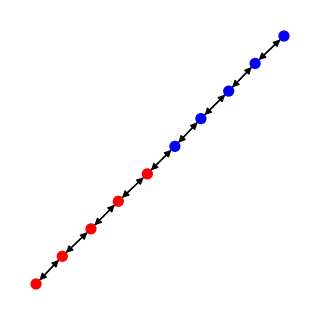

In [251]:
#adjacency matrix of network
A = nx.adjacency_matrix(G0)
A = A.tocoo()
n = A.shape[0]  #number of nodes in network


print(f"Network has {n} nodes, {G0.number_of_edges()} edges")
G = G0.copy()


if n<=100:
    colors = []
    for v in G.nodes():
        #print(f"{v}: {G.nodes[v]}")
        if (G.nodes[v]['opinion']<0.5) & (G.nodes[v]['opinion']>=0):
            colors.append('blue')
        elif (G.nodes[v]['opinion']>0.5) & (G.nodes[v]['opinion']<=1):
            colors.append('red')
        elif G.nodes[v]['opinion']==0.5:
            colors.append('purple')
        else:
            colors.append('green')
    pos = nx.kamada_kawai_layout(G)
    plt.figure(figsize = (3,3))
    nx.draw(G,pos, node_color = colors, node_size = 50)
    #nx.draw_networkx_labels(G,pos)

# Objective and Simulation Parameters

In [252]:
#objective function to be maximized
#OBJECTIVE can be "MEAN", "VAR","VAR_NEG", "MEAN_TAVG","VAR_TAVG","VAR_TAVG_NEG",'MEAN_TAVG'  
#TAVG = time average
OBJECTIVE = 'VAR_TAVG_NEG'
alpha   = 0.5  #Weight of control strength

# simulation time parameters
tmax = 2000 #tmax = tf = final time for simulation in [time units]
nsteps = 2000  #number of discrete steps in the simulation

print(f"Maximize {OBJECTIVE}\nSimulation has {nsteps} steps for t = 0 .. {tmax}")

Maximize VAR_TAVG_NEG
Simulation has 2000 steps for t = 0 .. 2000


# Run Simulation With No Agent

Run the opinion dynamics simulation with no agents.  This let's you see if the time scale and step for the simulation are ok.

Opinion simuator takes 0.25 seconds
Adjoint simuator takes 1.203125 seconds
No agent VAR_TAVG_NEG = -0.036827


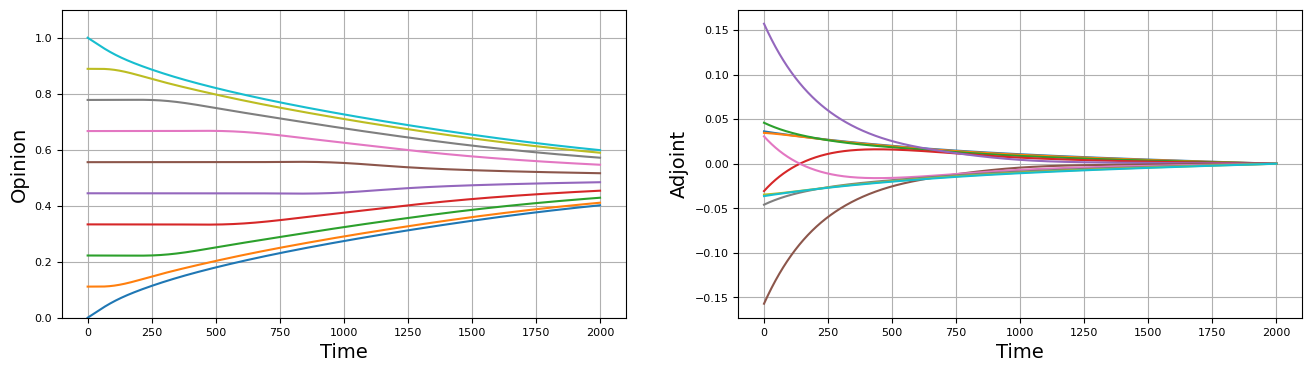

In [253]:
start = time.process_time()
Opinions, T = simulate_opinion(opinions0, rates, A, 
                                nsteps, tmax, tau, omega)
tsim = time.process_time() - start
print(f"Opinion simuator takes {tsim} seconds")

#########################
start = time.process_time()
pf = boundary_condition_Pf(OBJECTIVE, Opinions)

P, T = simulate_adjoint(pf, Opinions, rates, A, 
                        nsteps, tmax, tau, omega, OBJECTIVE)

tsim = time.process_time() - start
print(f"Adjoint simuator takes {tsim} seconds")
obj_no_agent = objective_value(OBJECTIVE, Opinions)
print(f"No agent {OBJECTIVE} = {obj_no_agent:.6f}")


Opinions_no_agent  = Opinions
P_no_agent  = P
################################################
plt.figure(figsize = (16,4))
plot_opinion_adjoint(T,Opinions_no_agent, P_no_agent)


# Calculate Policy for all Objectives 

In [254]:
OBJECTIVES = ['MEAN_TAVG','VAR_TAVG','VAR_TAVG_NEG']
PLOT = False
max_iter = 3
outputs = []

for OBJECTIVE in OBJECTIVES:
    obj_best = -float('inf')
    Obj = []

    for c in range(max_iter):
        if c ==0:
            Opinions, T = simulate_opinion(opinions0, rates, A, 
                                            nsteps, tmax, tau, omega)
        else:        
            Opinions, T = simulate_opinion_opt(opinions0, rates, A, 
                                            nsteps, tmax, tau, omega,
                                            P, alpha)


        obj = objective_value(OBJECTIVE, Opinions)
        print(f"Iteration {c}: {OBJECTIVE} = {obj:.6f}")    

        pf = boundary_condition_Pf(OBJECTIVE, Opinions)

        P, T = simulate_adjoint(pf, Opinions, rates, A, 
                            nsteps, tmax, tau, omega, OBJECTIVE)
        if PLOT:
            plt.figure(figsize = (16,3))
            plot_opinion_adjoint(T,Opinions, P)
            plt.show()
        #####################
        change = np.abs(obj_best-obj)
        Obj.append(obj)
        if obj > obj_best:
            obj_best = obj
            Tbest, Opinions_best, Pbest = T, Opinions, P
        c+=1
    output = (Tbest, Opinions_best, Pbest,obj_best)
    outputs.append(output)
    
    

Iteration 0: MEAN_TAVG = 0.500000
Iteration 1: MEAN_TAVG = 0.826895
Iteration 2: MEAN_TAVG = 0.826895
Iteration 0: VAR_TAVG = 0.036827
Iteration 1: VAR_TAVG = 0.122682
Iteration 2: VAR_TAVG = 0.203784
Iteration 0: VAR_TAVG_NEG = -0.036827
Iteration 1: VAR_TAVG_NEG = -0.022293
Iteration 2: VAR_TAVG_NEG = -0.024229


# Plot Opinion Distributions

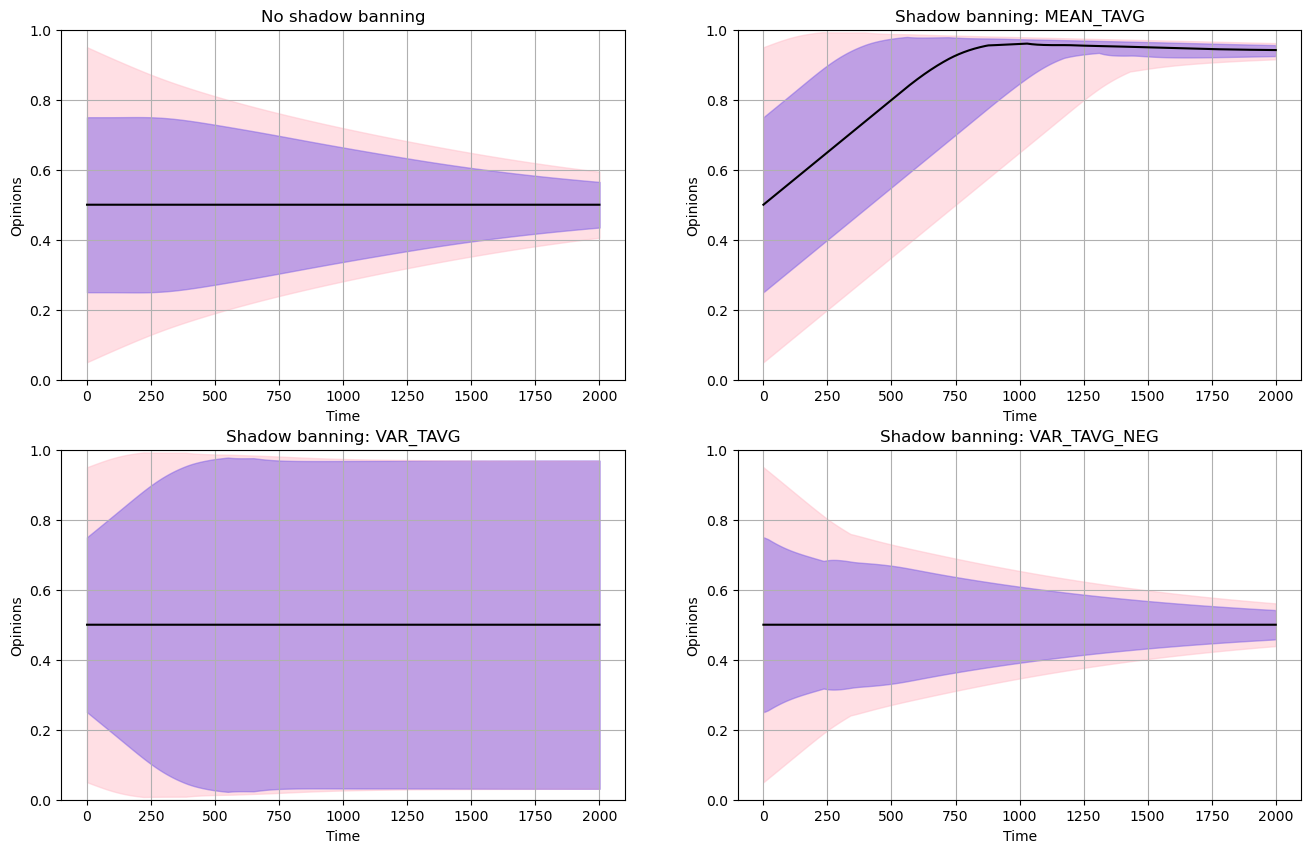

In [255]:
plt.figure(figsize = (16,10))
plt.subplot(2,2,1)
plot_opinion_quantiles(T, Opinions_no_agent)
plt.title(f"No shadow banning")
plt.ylim([0,1])

for cnt, output in enumerate(outputs):
    #plot opinion quantiles
    #T, Opinions_best, _ = output
    #obj_best = 1
    T, Opinions_best, _,obj_best = output

    OBJECTIVE = OBJECTIVES[cnt]
    obj_no_agent = objective_value(OBJECTIVE, Opinions_no_agent)



    plt.subplot(2,2,cnt+2)
    plot_opinion_quantiles(T,Opinions_best)
    plt.title(f"Shadow banning: {OBJECTIVE}")
    plt.ylim([0,1])
plt.savefig('figures/linear_network_opinions.pdf')
plt.show()


# Draw Networks with Control Weighted Edges

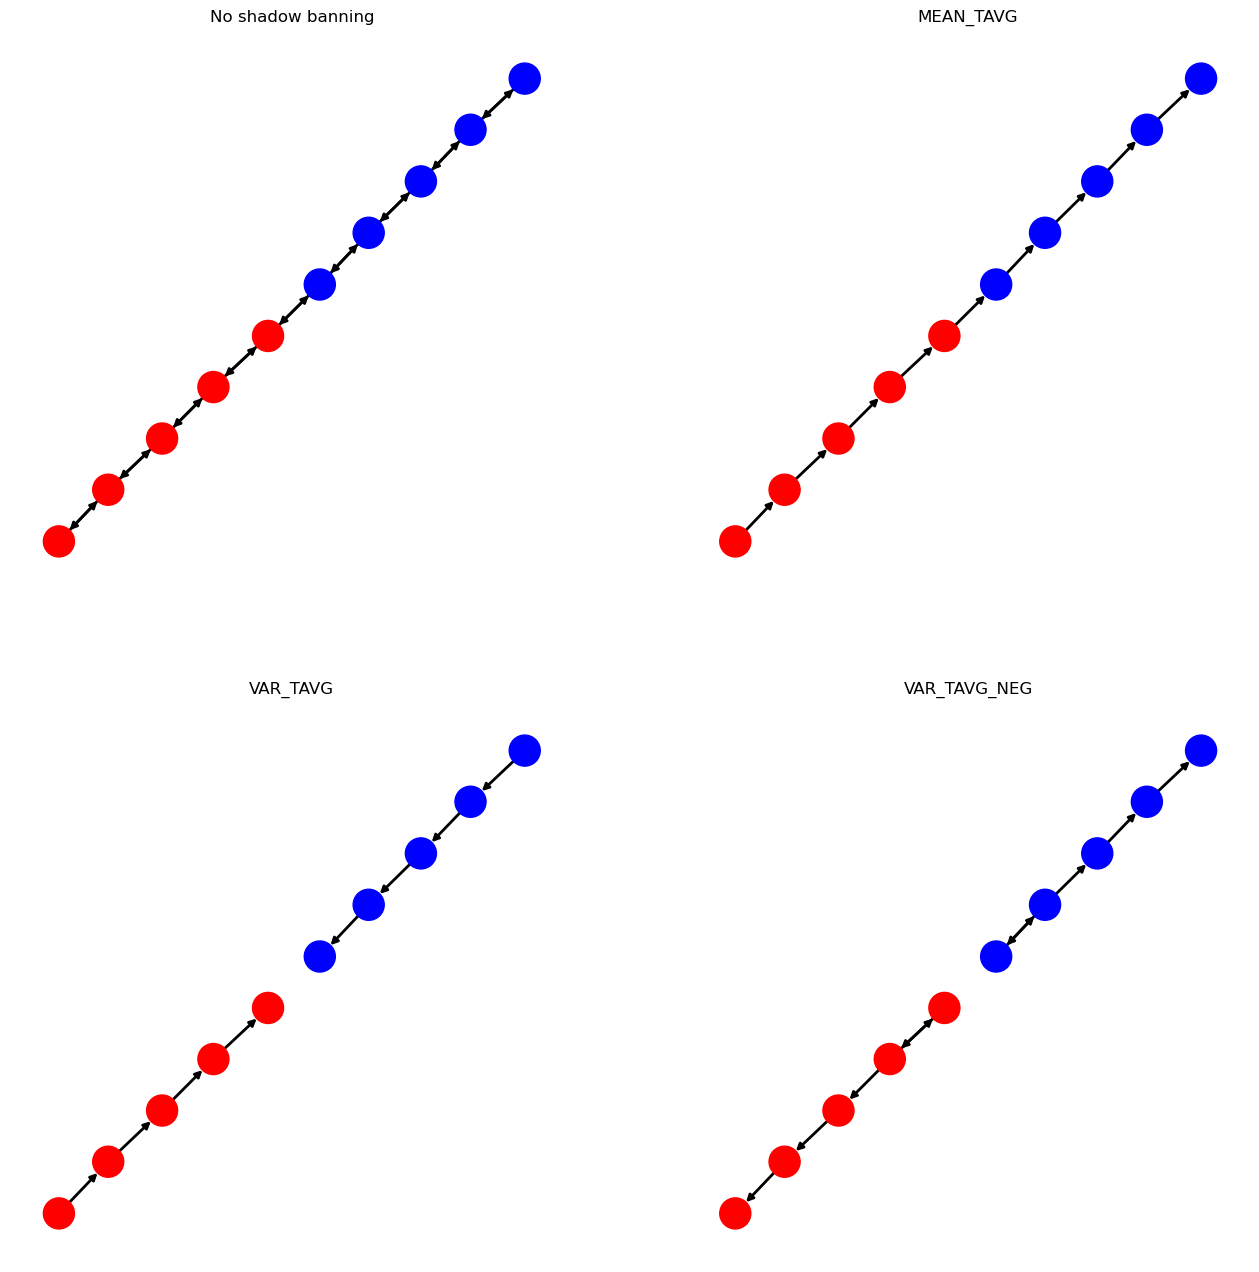

In [256]:
node_size = 500
edge_width = 2
tind = 0
plt.figure(figsize = (16,16))
plt.subplot(2,2,1)
nx.draw(G0, pos, node_color = colors, node_size = node_size,
       width = edge_width)
plt.title(f"No shadow banning")


for cnt, output in enumerate(outputs):
    OBJECTIVE = OBJECTIVES[cnt]

    T, Opinions_best, Pbest, _ = output
    opinions = Opinions_best[tind,:]
    ps = Pbest[tind,:]
    Ustar = shadowban_opt(opinions, ps, rates, A, tau, omega, alpha, tmax)

    A1 = A.multiply(Ustar)
    row_indices, col_indices, values = sp.find(A1)

    G = nx.DiGraph()
    G.nodes = G0.nodes
    for u, v, weight in zip(row_indices, col_indices, values):
        G.add_edge(u, v, weight=weight*edge_width)
        

    weights = nx.get_edge_attributes(G, 'weight').values()
    plt.subplot(2,2,cnt+2)
    nx.draw(nx.DiGraph(G),pos, node_color = colors, node_size = node_size,
           width=list(weights))
    plt.title(OBJECTIVE)
plt.savefig('figures/linear_networks.pdf')
plt.show()

# Plot Control Strength

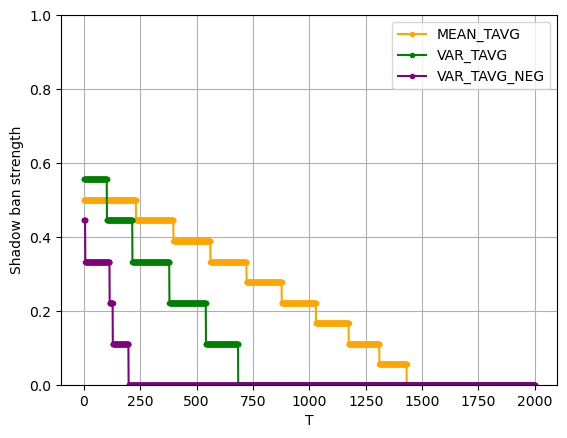

In [257]:
colors_plot = ['orange','green','purple']
for cnt, output in enumerate(outputs):
    OBJECTIVE = OBJECTIVES[cnt]
    color = colors_plot[cnt]
    T, Opinions_best, Pbest, _ = output
    Opinions = Opinions_best
    P = Pbest

    Shadowban_strength = []
    for tind in range(len(T)):
        opinions = Opinions[tind,:]
        ps = P[tind,:]
        Ustar = shadowban_opt(opinions, ps, rates, A, tau, omega, alpha, tmax)
        if len(Ustar.data) >0:
            shadowban_strength = 1-np.mean(Ustar.data)
        else:
            shadowban_strength = 0
        Shadowban_strength.append(shadowban_strength)
    Shadowban_strength = np.array(Shadowban_strength )
    
    plt.plot(T,Shadowban_strength, marker = '.', color = color, label = OBJECTIVE)
plt.legend()
plt.grid()
plt.xlabel('T')
plt.ylabel("Shadow ban strength")
plt.ylim([0,1])
plt.savefig('figures/linear_network_control_strength.pdf')

plt.show()

# Debugging 

In [192]:
cnt = 2
output = outputs[cnt]
OBJECTIVE = OBJECTIVES[cnt]
color = colors_plot[cnt]
T, Opinions_best, Pbest, obj_best = output
Opinions = Opinions_best
P = Pbest

Shadowban_strength = []
for tind in range(len(T)):
    opinions = Opinions[tind,:]
    ps = P[tind,:]
    Ustar = shadowban_opt(opinions, ps, rates, A, tau, omega, alpha, tmax)
    if len(Ustar.data) >0:
        shadowban_strength = 1-np.mean(Ustar.data)
    else:
        shadowban_strength = 1 #Ustar = 0 -> shadow ban all edges
    
  
    Shadowban_strength.append(shadowban_strength)
Shadowban_strength = np.array(Shadowban_strength )

print(obj_best)

-0.013762445991131108


Text(0, 0.5, 'Shadow ban strength')

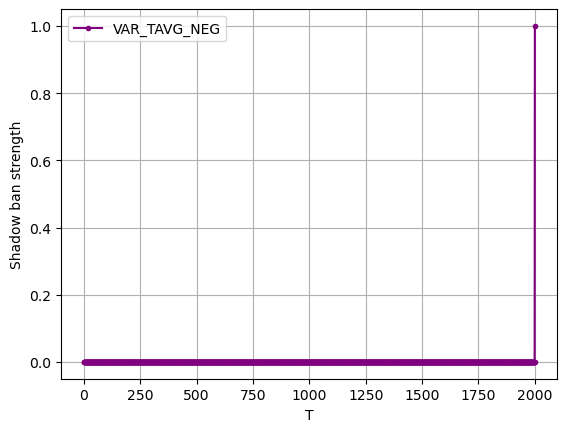

In [193]:
plt.plot(T,Shadowban_strength, marker = '.', color = color, label = OBJECTIVE)
plt.legend()
plt.grid()
plt.xlabel('T')
plt.ylabel("Shadow ban strength")
#plt.ylim([0,1])

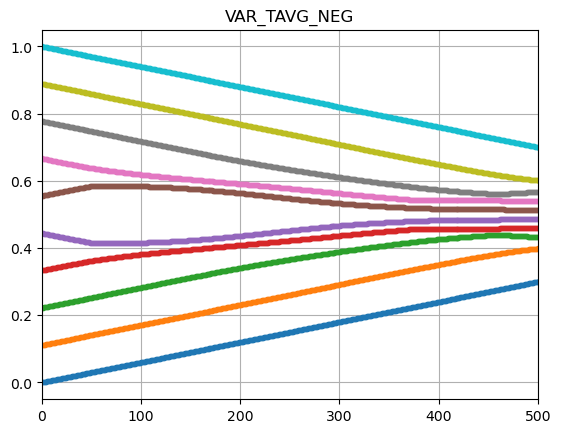

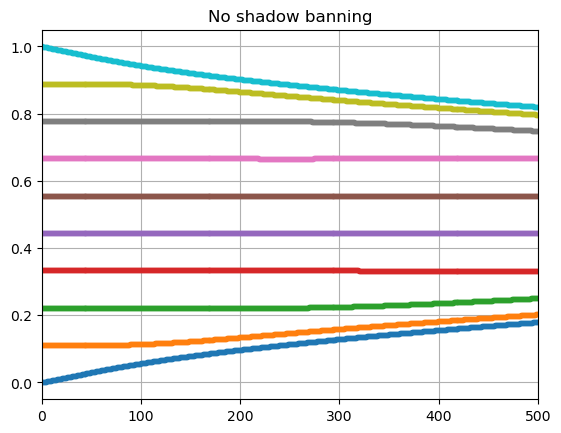

In [228]:
plt.plot(Opinions,'.')
plt.xlim([0,500])
plt.title(OBJECTIVE)
plt.grid()
plt.show()
plt.plot(Opinions_no_agent,'.')
plt.xlim([0,500])
plt.title("No shadow banning")

plt.grid()
plt.show()

In [244]:
tind = 1
opinions = Opinions[tind,:]
ps = P[tind,:]
n = len(rates)
data = shift(opinions[A.row]- opinions[A.col],tau,omega) #shift value
Shift_matrix = coo_matrix((data, (A.row, A.col)), shape=A.shape)
Ustar = shadowban_opt(opinions, ps, rates, A, tau, omega, alpha, tmax)
Ustar.sum()

18

In [245]:
data = shift(opinions[A.row]- opinions[A.col],tau,omega) #shift value
Shift_matrix = coo_matrix((data, (A.row, A.col)), shape=A.shape)
C = Shift_matrix.multiply(np.outer(np.array(rates), ps))
C = C.multiply(A)
ne = A.sum()
nonzero_elements = C.data  # Get the non-zero elements of C
result = (nonzero_elements >= -alpha/ne/tmax).astype(int) # Perform element-wise comparison

row_indices, col_indices = C.nonzero()
Ustar = csr_matrix((result, (row_indices, col_indices)), shape=C.shape)

In [246]:
ps

array([ 0.02746675,  0.0106785 ,  0.00707278,  0.00719492,  0.01265995,
       -0.01265995, -0.00719492, -0.00707278, -0.0106785 , -0.02746675])

In [247]:
nonzero_elements 

array([-6.40007065e-06,  1.64619661e-05, -4.23901340e-06,  6.40007065e-06,
       -4.31220831e-06,  4.23900690e-06, -7.60589591e-06,  4.32259389e-06,
        7.56743970e-06,  7.56743970e-06,  4.32259389e-06, -7.60589591e-06,
        4.23900690e-06, -4.31220831e-06,  6.40007065e-06, -4.23901340e-06,
        1.64619661e-05, -6.40007065e-06])

In [248]:
-alpha/ne/tmax

-2.7777777777777776e-05

In [249]:
result

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])